This is a simple example how to use the capabilities of the maptrack module.
The notebook has been run on Python 3.8.5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.version.split(' ')[0]

'3.8.5'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from shutil import copyfile

import maptrack.helpers as hs
import simple_map as sm
import fast_track as ft

All the auxiliary files can be found in the adjacent madx folder.
We are going to need a sequence to create the maps from and our map generating template. Remember to run additional routines such as matching macros before the maps are generated!

First let's make a settings object, which we will later execute to create PTC map files as well as tracking files that we will use for benchmarking

In [4]:
#Please use ABSOLUTE paths

PARENTDIR = '/home/sotal/Documents/CERN/cernbox'

outputdir = '{}/Repos/maptrack_sympy/maptrack/tutorial'.format(PARENTDIR) #program generates folder here to dump files
settings = sm.Settings('hellomaps',outputdir=outputdir,debug=True)

settings.madxversion = '{}/madx'.format(PARENTDIR)
settings.template = '{}/Repos/maptrack_sympy/maptrack/tutorial/madx/get_maps_template.madx'.format(PARENTDIR)
settings.seqfile = '{}/Repos/maptrack_sympy/maptrack/tutorial/madx/seq.madx'.format(PARENTDIR) 
#seqfile will be executed before making maps


In [5]:
with open(settings.seqfile,'r') as f:
    for line in f:
        print(line) #Feel free to uncomment this line to take a look at your seqfile
        pass

! Define element classes for a simple cell:

k: hkicker, kick = 1e-4;

b: sbend, l = 35.09, angle = 0.011306116;

qf: quadrupole, l = 1.6, k1 = -0.02268553;

qd: quadrupole, l = 1.6, k1 = 0.022683642;

sf: sextupole, l = 0.4, k2 = -0.13129;

sd: sextupole, l = 0.76, k2 = 0.26328;





! define the cell as a sequence:

sequ: sequence, l = 79;

k1: k, at = 0;

b1: b, at = 19.115;

sf1: sf, at = 37.42;

qf1: qf, at = 38.70;

b2: b, at = 58.255, angle = b1->angle;

sd1: sd, at = 76.74;

qd1: qd, at = 78.20;

endm: marker, at = 79.0;

endsequence;





beam,particle=proton;



MYMARKER:marker; !PTC sector starting/ End point



use,sequence=sequ;



seqedit,sequence=sequ;

INSTALL, ELEMENT = MYMARKER, at =qf1->L/2, FROM =qf1;

FLATTEN;

ENDEDIT;



use, sequence=sequ;



Twiss, file=myseq.tfs;













The settings will need to know the name of the active sequence we will map, as well as the characteristics of our beam. Make sure this agrees with your seqfile beam attributes! 

In [6]:
settings.seqname='sequ'
settings.pc = '1.0'
settings.particle = 'proton'

We are going to specify the sectors we want to get maps of. Here are the main guidelines:

- sectors is a list of tuples with [(START_SECTOR0_ELE, END_SECTOR0_ELE), ..., (START_SECTOR-1_ELE, END_SECTOR-1_ELE) ]. 
- The program will install markers BEFORE these elements.
- Try to stay periodic (sectors[0][0]=sectors[-1][1]) and continous (sectors[n][1]=sectors[n+1][1]). This will make benchmarking easy. Break these conditions at your own risk!!

We are going to stick to one sector that start and ends at MYMARKER. i.e. we are going to create a one turn map.

In [7]:
settings.sectors = [('MYMARKER','MYMARKER')]

It's time to specify the characteristics of our map. You can read more about the details in the MADX guide for the PTC library

In [8]:
settings.mapping = True #Do I want to generate PTC maps?

settings.PTCkwargs ={'pyMAP_ORDER':'3', #Order of non-linearity
                'pyMODEL_PTC':'2', #1 = drift-kick-drift, 2 = matrix-kick-matrix, 3 = Delta-matrix-kick-matrix (SixTrack)
                'pyMETHOD_PTC':'6', #integration order: 2,4,6
                'pySLICE_NUMBER':'5', 
                'pyICASE_PTC':'5'} #Phase space dimensions: 4,5,6}

Now let's set up the tracking of a few particles that will serve us for benchmarking our maps.

In [9]:
settings.tracking = True #Do I want to track benchmarking particles?
settings.trackkwargs = {'pyNTURNS':'1000',  #Number of tracked turns
                        'pyNORM_NO':'15'} #Norm of the ptc_tracking routine. Keep it high!
                        
settings.initialconditions = [{'x':i*10.5e-3/50.0,
                        'px':0.000,
                        'y':0,
                        'py':0,
                        't':0,
                        'pt':0.001/50.0} for i in range(50)] #Initial conditions for tracking/benchmarking

We give the option to replace any text in the mapping template with a user input. This is done through the myreplace attribute. Some stadard placeholders are already in place (check the template). E.g. 

In [10]:
settings.myreplace={'/*pyPREMAPPING*/':'!This is a comment',
'/*pyPRETRACKING*/':'!This is another comment',
'/*pyPOSTTRACKING*/':'!Hopefully it is clear :)'} #Some standard placeholders already in the template

In [11]:
with open(settings.template,'r') as f:
    for line in f:
        print(line) #Feel free to uncomment this line to take a look at your mapping template
        pass

!-----------------------------------------------------------------------

!TEMPLATE FOR PTC MAPS using simple_map/main.py

!

!

!@author: Pablo Arrutia

!-----------------------------------------------------------------------











get_sector_map_ptc(start_ele, end_ele, nsector): macro = {



    !----------------------------------------------------------------------!

    !Save closed orbit map (for initial conditions) [+ closed orbit optics]!

    !----------------------------------------------------------------------!



    use, sequence = pySEQ;



    seqedit, sequence = pySEQ;

    flatten;

    cycle, start = start_ele;

    endedit;



    use, sequence = pySEQ;



    !Regular twiss!

    !-------------!

    

    select, flag=twiss, clear;

    !select, flag=twiss, column=name,s,l,x,betx,dx,aper_1,y,bety,dy,aper_2, alfx, alfy, px, py, mux, muy,k2l, dpx, dpy;

    twiss, deltap=dpp;

    write, table=twiss, file='pyDATADIR/twiss/nsector_twiss_ref.tfs';



    !PTC twis

We are ready! If you only want the files and executables generation then you can switch run_madx to false. This is mainly for debugging purposes. 

If madx gives "+++ memory access outside program range, fatal +++", try rerunnig the job. Usually it is related to a problem with reading/writing of files

In [12]:
settings.run_madx=True
sm.run_job(settings)

/home/sotal/Documents/CERN/cernbox/Repos/maptrack_sympy/maptrack/simple_map/main.py:210: UserWarning: DEBUGGING MODE is ON
  warnings.warn("DEBUGGING MODE is ON")


Executable is ready...
Output Directories created...
Looking for MADX errors/warnings... (Debug ON)
MADX warnings: 

  Number of warnings: 0

MADX fatal errors:

Job Finished!


In [13]:
settings.datadir

'/home/sotal/Documents/CERN/cernbox/Repos/maptrack_sympy/maptrack/tutorial/hellomaps/'

We are looking good. Feel free to explore the output folder, which should be located in the datadir path above. I will directly go to the benchmarking.

Closed orbit in x_1 is 0.0037957125707638976.
We remove it for tracking! Be careful :)
Closed orbit in x_2 is 6.981570186903717e-05.
We remove it for tracking! Be careful :)


/home/sotal/Documents/CERN/cernbox/Repos/maptrack_sympy/maptrack/maptrack/helpers.py:334: UserWarning: Attempting to set identical bottom == top == 0.02 results in singular transformations; automatically expanding.
  ax.set_ylim([pt_min-(pt_max-pt_min)/50.0,pt_max+(pt_max-pt_min)/50.0])


{'djx': array([3.46052437e-08, 4.54108933e-08, 2.55314057e-07, 8.18237744e-07,
        1.85189708e-06, 3.15588868e-06, 6.17727685e-06, 1.39374413e-05,
        2.94161383e-05, 6.16616727e-05, 1.20783343e-04, 2.27201819e-04,
        4.55984859e-04, 8.80340426e-04, 2.22183336e-03, 9.21147276e-03,
        8.48253618e-03, 4.74902964e-03, 3.76666242e-03, 3.46215972e-03,
        3.28988275e-03, 3.26169339e-03, 3.28392551e-03, 3.37328107e-03,
        3.48914642e-03, 3.65041462e-03, 4.08859652e-03, 4.63010080e-03,
        5.10851546e-03, 5.91598627e-03, 6.71216458e-03, 8.04887069e-03,
        1.05379071e-02, 1.50656435e-02, 1.96218904e-02, 2.44956191e-02,
        3.29171305e-02, 4.31756982e-02, 5.17765861e-02, 6.82882299e-02,
        8.04506341e-02, 1.04355312e-01, 1.18405123e-01, 1.49626115e-01,
        1.77365586e-01, 2.19893293e-01, 2.82657213e-01, 3.66100221e-01,
        4.37159411e-01, 6.19345286e-01]),
 'map': {'xn': array([[ 0.00081384,  0.00081734,  0.00082003, ...,  0.0008187 ,
       

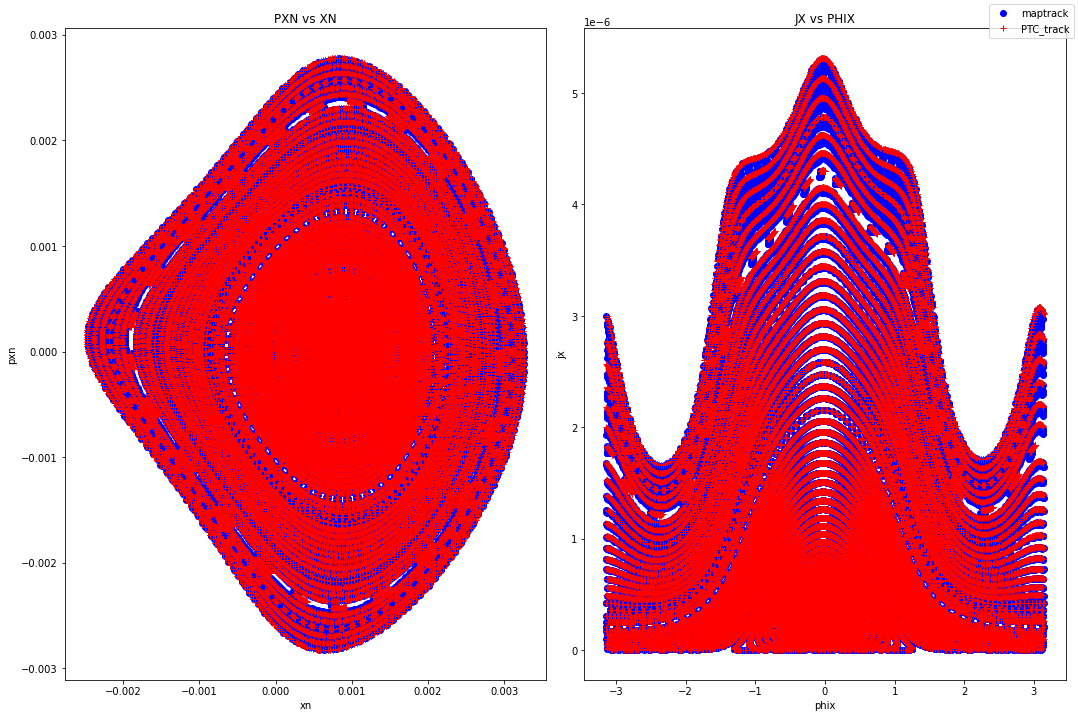

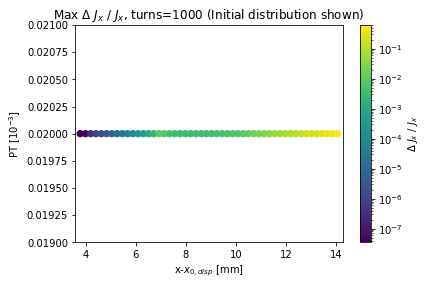

In [14]:
hs.benchmark(settings.datadir)

Wow look at that! The way we are benchmarking our maps is by looking at the max error in action J_x when comparing our maps and the PTC tracking. Feel free to play around with the map generation settings and the distribution of tracked particles to further explore the module. I will just check the tune:

In [19]:
header,data = hs.readtfs(settings.datadir+'/twiss/00000_twiss_ref.tfs')
print(header['Q1'])


0.26281424722343955


Finally, let's demonstrate how to use the maps in python.

In [36]:
#Create python maps from PTC files
import glob

pymaps = {}
mapsdir = settings.datadir+'maps'

for n,filename in enumerate(sorted(glob.glob(os.path.join(mapsdir, '*_ptc_map_sector*.tfs')))):
    pymaps[n] = hs.getPTCmap(filename)

Closed orbit in x_1 is 0.0037957125707638976.
We remove it for tracking! Be careful :)
Closed orbit in x_2 is 6.981570186903717e-05.
We remove it for tracking! Be careful :)


We have our maps ready. We can explore different maps and their expansions really easily. In this case we only have one map named '0':

The value of the dictionary is a 2-tuple. The first element contains a dictionary with the functions for tracking. The second element has the same thing but in human readable form! Let's see...

In [38]:
pymaps[0][1].keys()

dict_keys([1, 2, 3, 4, 5, 6])

Each key corresponds to a phase space variable which are basically the madx variables:

$$x_i = x, x', y, y', p_t, t$$

And so the maps are effectively saying 'update by variables according to'

$$x_i \leftarrow f_i(x)$$,

where $f_i$ is stored in the value of the dictionary. 

Let's take a look at the expression for x:

In [39]:
# As mentioned, we are looking at x <- pymaps['0'][1][1]
pymaps[0][1][1]

1.96366347237754*\delta**3 + 174.824549769672*\delta**2*p_x + 3.47481735597599*\delta**2*x - 1.06960359329712*\delta**2 + 22638.1414959444*\delta*p_x**2 + 808.20317538044*\delta*p_x*x - 33.9068469457053*\delta*p_x - 18699.0528122214*\delta*p_y**2 - 705.492954639224*\delta*p_y*y + 5.21974610980863*\delta*x**2 - 0.233421922557007*\delta*x - 4.7446229931558*\delta*y**2 + 0.815810328943972*\delta - 7484.26952506821*p_x**3 - 17.1658827400797*p_x**2*x - 5630.47845980583*p_x**2 - 153055.780871724*p_x*p_y**2 - 6784.72769946376*p_x*p_y*y + 15.3078802076427*p_x*x**2 - 304.819813150183*p_x*x - 71.8640496922984*p_x*y**2 + 21.6819845471695*p_x - 4698.57020527277*p_y**2*x + 4676.36213424362*p_y**2 - 213.664076715945*p_y*x*y + 267.714203895552*p_y*y + 0.278120441761117*x**3 - 4.0687062324966*x**2 - 2.35079934845526*x*y**2 - 0.513133144684428*x + 3.74705000782842*y**2

That's the whole expansion! You can extract information from the coefficients if you are feeling inspired (and you are well versed in a bunch of fancy math).

Now we can also do some tracking. Our initial distribution will look like this (I'm lazy so I just make copies of 2 different initial conditions, feel free to make something nicer):

Text(0, 0.5, 'PX')

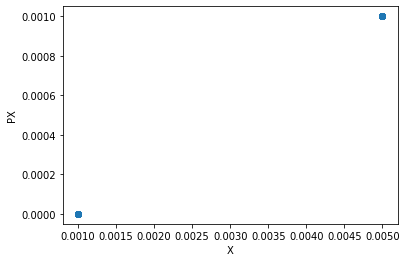

In [40]:
# CAREFUL! The coordinates are always defined with respect to the center of the beam pipe!
# If your closed orbit is non-zero you should add it as well (see next cell)

copies = 10

particles0 = np.array([[0.001,0.005]*copies, #Xs
                      [0,0.001]*copies, #PXs
                      [0,0.00]*copies, #Ys
                      [0,0]*copies, #PYs
                      [0,0]*copies, #Ts
                      [0,0.01]*copies]) #PTs

plt.plot(particles0[0,:],particles0[1,:],'o')
plt.xlabel('X')
plt.ylabel('PX')

We can now track the particles and plot the result!

In [43]:
nturns=200

particles_map = np.zeros((6,particles0.shape[1],nturns+1))
co_vector = data.iloc[0][['X', 'PX', 'Y', 'PY', 'T', 'PT']]
co_vector = np.float64([co_vector]).T
particles_map[:,:,0] = particles0 + co_vector # Add closed orbit

for trn in range(1,nturns+1):
    particles_tmp = hs.trackPTC(particles_map[:,:,trn-1],1, 68, co_vector, [pymaps[key][0] for key in sorted(pymaps)],
                                        [pymaps[key][1] for key in sorted(pymaps)])
    particles_map[:,:,trn] = particles_tmp[:,:]

Text(0, 0.5, 'PX')

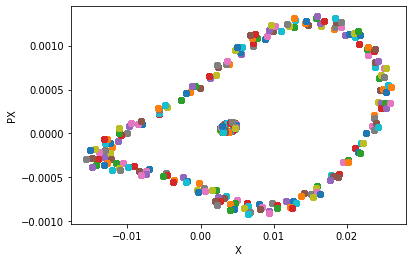

In [44]:
plt.plot(particles_map[0,:,:],particles_map[1,:,:],'o');
plt.xlabel('X')
plt.ylabel('PX')